In [31]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import BaggingRegressor, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

## 1) Bagging
Para esse exercício, precisaremos de novos dados, dessa vez das eleições municípais de 2000. A base que usaremos indica qual partido venceu, se PMDB/PSDB/PFL ou outros, e variáveis econômicas e demográficas (não se esqueça de remover IDs e nome dos municípios, como cod_mun_ibge e nome_municipio; se usar Python, também não se esqueça de transformar/remover as variáveis uf e coligacao):

In [2]:
link = 'https://raw.githubusercontent.com/FLS-6497/datasets/main/aula7/eleicoes2000.csv'
dados = pd.read_csv(link, sep=';', decimal=",").drop(['cod_mun_ibge', 'nome_municipio'], axis=1)

In [3]:
dados

,uf,partido,coligacao,n_partidos,espvida,mort1,e_anosestudo,t_analf25m,ppob,rdpc,agua_esgoto,i_escolaridade,p_super,t_des18m,gini
0,AC,PMDB-PSDB-PFL,Coligado,4,68.43,25.45,8.71,18.62,50.89,527.43,29.90,0.425,7.26,13.48,0.61
1,AC,PMDB-PSDB-PFL,Coligado,3,67.39,28.33,6.58,48.37,79.68,238.86,28.34,0.165,2.02,3.95,0.64
2,AC,PMDB-PSDB-PFL,Coligado,2,66.07,32.20,6.96,37.73,74.50,217.70,42.23,0.173,1.23,14.94,0.54
3,AL,Outros,Coligado,3,64.21,46.61,4.98,62.15,91.77,98.98,23.72,0.098,0.00,0.85,0.66
4,AL,Outros,Coligado,5,63.52,49.30,6.60,39.73,87.35,168.82,14.90,0.192,1.03,39.90,0.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5002,SP,Outros,Coligado,11,73.07,18.06,10.06,6.20,18.34,1223.77,0.67,0.568,17.99,14.58,0.57
5003,SP,Outros,Coligado,8,72.20,19.08,10.07,8.01,28.84,694.75,1.26,0.477,7.73,19.57,0.52
5004,SP,Outros,Coligado,6,71.41,20.70,9.84,8.92,28.23,597.35,0.30,0.454,4.09,20.33,0.46
5005,SP,Outros,Coligado,16,72.75,18.44,10.30,6.03,20.87,1216.54,0.34,0.565,16.70,16.23,0.61


### a) Exploração
Explore rapidamente a base de dados. Para tanto, você pode criar gráficos com as distribuições do target e de algumas features, com cruzamentos das variáveis ou, ainda, usar correlações. Quais variáveis parecem ter mais relação com o target partido?

In [4]:
dados[['outros_partidos', 'pmdb_psdb_pfl']] = pd.get_dummies(dados.partido)

<AxesSubplot: >

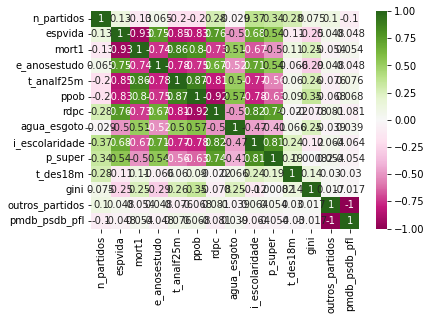

In [5]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 8]
(
    sns.heatmap(
        dados.corr(), 
        annot=True, 
        annot_kws={"fontsize":10}, 
        cmap="PiYG"
        )
    )
# correlações muito baixas - rdpc, t_analf25m, ppob, i_escolaridade,mort1, p_super - em ordem 

In [6]:
dados_dummies = (
    pd.concat([
        dados, 
        pd.get_dummies(dados.uf)
        ], 
        axis=1
        )
    )
dados_dummies = dados_dummies.drop(['uf', 'coligacao', 'partido', 'outros_partidos'], axis=1)

### b) Criação de pipelines com bagging
Usando pipelines, crie um bagging ensemble combinando quantos e quais modelos você quiser e outra pipeline usando Naive Bayes. Treine e compare os resultados destas pipelines.

In [30]:
y = dados_dummies.pmdb_psdb_pfl
X = dados_dummies.loc[:, dados_dummies.columns != 'pmdb_psdb_pfl']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

gnb = GaussianNB().fit(X_train, y_train)

bag = (
    BaggingRegressor(
        base_estimator=GaussianNB(), 
        n_estimators=10
        )
        .fit(X_train, y_train)
        )

y_pred_gnb = gnb.predict(X_test)
print(mean_squared_error(y_test, y_pred_gnb, squared=False))

y_pred_bag = bag.predict(X_test)
print(mean_squared_error(y_test, y_pred_bag, squared=False))

0.7012013263439635
0.637333725853611


### c) Variações
Agora, crie outros dois bagging ensembles, um deles fazendo subsample dos dados (no mlr3, isso é controlado pelo argumento frac no po com subsample) e, o outro, utilizando um modelo diferente do que você utilizou na bagg anterior. Treine e compare os resultados destas novas pipelines.

### d) Random forest
Crie uma pipeline agora usando random forest (fique à vontade para customizar ela como achar melhor) e compare seus resultados com o da melhor pipeline que você encontrou no exercício anterior.

In [32]:
rfc = RandomForestClassifier().fit(X_train, y_train)

bag_rfc = (
    BaggingRegressor(
        base_estimator=RandomForestClassifier(), 
        n_estimators=10
        )
        .fit(X_train, y_train)
        )

y_pred_rfc = rfc.predict(X_test)
print(mean_squared_error(y_test, y_pred_rfc, squared=False))

y_pred_bag_rfc = bag_rfc.predict(X_test)
print(mean_squared_error(y_test, y_pred_bag_rfc, squared=False))

0.6334016141362596
0.5650852655001979


## 2) Stacking
### a) Básico
Adaptando o exemplo dos materiais de aula, crie uma pipeline que use stacking para combinar os resultados de três modelos diferentes. Os modelos de nível 0 podem ter tanto etapas de pré-processamento, modelos ou parâmetros diferentes (e.g., é possível treinar 3 árvores diferentes). Como blender, use um modelo de regressão logística simples (no mlr3, classif.log_ref; no sklearn, LogisticRegression). Treine e veja os resultados desta pipeline.

### b) Ensemble em cima de ensemble
Ao stack anterior, adapte e adicione agora o melhor bagging ensemble que você encontrou no exercício 1. Treine e veja o resultado dessa nova versão.

## 3) Boosting
Para quem usa R, neste exercício será necessário converter features categóricas para numeric (o XGboost só aceita variáveis numéricas). Podemos criar uma nova base assim com o seguinte código:

### a) Gradiente
Treine dois ensembles com boosting, um usando gradient boosting e, o outro, extreme gradient boosting. Compare os resultados.

### b) Número de árvores em boosting
Usando extreme boosting, crie três pipelines: uma que treine 10 modelos, outra que treine 100 e, por fim, uma que treine 200. O que acontece com os resultados?

## 4) Valiação
Usando o melhor ensemble que você encontrou nessa aula, o valide usando estes dados das eleições de 2004 – que foram um pouco diferentes das de 2000 em termos de desempenho dos partidos (lembre-se de que é preciso treinar do zero o melhor modelo nos dados completos de 2000 antes de fazer a validação).2.

## Bônus
Tente adaptar o uso de algum ensemble que vimos para o Projeto 1 e veja se você consegue melhorar a performance do seu modelo de classificação de discursos presidenciais.